In [6]:
# FRAUD DETECTION ANALYTICS SYSTEM
!pip install -q pandas numpy scikit-learn imbalanced-learn matplotlib seaborn mysql-connector-python openpyxl



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 56.0 MB/s eta 0:00:00


In [7]:
# ====================================================================
# STEP 1: IMPORTS & SETTINGS
# ====================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, accuracy_score, precision_score, recall_score)
from imblearn.over_sampling import SMOTE

# Visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

np.random.seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [8]:
# ====================================================================
# STEP 2: DATA GENERATION (Simulating Financial Transaction Data)
# ====================================================================
def generate_transaction_data(n_samples=50000, fraud_ratio=0.02, random_state=42):
    """
    Generate realistic financial transaction data with fraud patterns.
    This version uses safe sampling so it never tries to sample from an empty subset.
    """
    np.random.seed(random_state)

    # Base fields
    data = {
        'transaction_id': [f'TXN{str(i).zfill(8)}' for i in range(1, n_samples + 1)],
        'customer_id': np.random.randint(10000, 99999, size=n_samples),
        'transaction_amount': np.random.lognormal(4, 1.5, size=n_samples),
        'transaction_hour': np.random.randint(0, 24, size=n_samples),
        'day_of_week': np.random.randint(0, 7, size=n_samples),
        'merchant_category': np.random.choice(
            ['retail', 'online', 'grocery', 'fuel', 'restaurant', 'entertainment', 'travel', 'healthcare'],
            size=n_samples
        ),
        'transaction_type': np.random.choice(
            ['card_present', 'card_not_present', 'online', 'atm'],
            size=n_samples,
            p=[0.4, 0.3, 0.25, 0.05]
        ),
        'location_match': np.random.choice([1, 0], size=n_samples, p=[0.9, 0.1]),
        'device_type': np.random.choice(['mobile', 'desktop', 'pos_terminal', 'atm'], size=n_samples),
    }

    df = pd.DataFrame(data)

    # Add timestamp (random day in 2024)
    start_date = datetime(2024, 1, 1)
    df['transaction_date'] = [
        start_date + timedelta(days=int(x)) for x in np.random.randint(0, 365, size=n_samples)
    ]
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])

    # Feature engineering
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_night'] = df['transaction_hour'].apply(lambda x: 1 if (x >= 22 or x <= 6) else 0)
    df['is_high_risk_category'] = df['merchant_category'].isin(['online', 'travel', 'entertainment']).astype(int)

    # Customer behavior features
    customer_avg = df.groupby('customer_id')['transaction_amount'].transform('mean')
    df['amount_vs_avg'] = df['transaction_amount'] / (customer_avg + 1e-9)  # avoid div by zero

    # Transaction velocity (per customer per day)
    df['transaction_count'] = df.groupby(['customer_id', df['transaction_date'].dt.date]).cumcount() + 1

    # Initialize fraud label
    df['is_fraud'] = 0
    n_frauds = max(1, int(n_samples * fraud_ratio))  # ensure at least 1 if fraction > 0

    # Helper: safe sampling from a mask
    def safe_sample_indices(mask, desired_n):
        subset = df[mask]
        # sample up to available rows in subset
        n = min(int(desired_n), len(subset))
        if n <= 0:
            return pd.Index([])
        return subset.sample(n=n, random_state=random_state).index

    # Define desired numbers per pattern (they sum to n_frauds or less due to overlap)
    n1 = int(n_frauds * 0.30)
    n2 = int(n_frauds * 0.25)
    n3 = int(n_frauds * 0.25)
    n4 = int(n_frauds * 0.20)

    # Fraud Pattern 1: high amount & night & card_not_present/online
    mask1 = (
        (df['transaction_amount'] > df['transaction_amount'].quantile(0.95)) &
        (df['is_night'] == 1) &
        (df['transaction_type'].isin(['card_not_present', 'online']))
    )
    fraud_idx1 = safe_sample_indices(mask1, n1)

    # Fraud Pattern 2: many transactions in short time (transaction_count > 5)
    mask2 = (df['transaction_count'] > 5)
    fraud_idx2 = safe_sample_indices(mask2, n2)

    # Fraud Pattern 3: location mismatch + above median amount
    mask3 = (df['location_match'] == 0) & (df['transaction_amount'] > df['transaction_amount'].median())
    fraud_idx3 = safe_sample_indices(mask3, n3)

    # Fraud Pattern 4: high risk category & amount_vs_avg > 3
    mask4 = (df['is_high_risk_category'] == 1) & (df['amount_vs_avg'] > 3)
    fraud_idx4 = safe_sample_indices(mask4, n4)

    # Combine indices (set union to avoid duplicates)
    fraud_indices = list(set(list(fraud_idx1) + list(fraud_idx2) + list(fraud_idx3) + list(fraud_idx4)))

    # If total flagged < n_frauds, randomly add additional frauds from remaining pool
    if len(fraud_indices) < n_frauds:
        remaining = df.index.difference(fraud_indices)
        add_n = min(n_frauds - len(fraud_indices), len(remaining))
        if add_n > 0:
            extra = df.loc[remaining].sample(n=add_n, random_state=random_state).index
            fraud_indices += list(extra)

    # Mark frauds
    df.loc[fraud_indices, 'is_fraud'] = 1

    # Inflate fraud amounts slightly to mimic fraud behavior
    n_marked = df['is_fraud'].sum()
    if n_marked > 0:
        df.loc[df['is_fraud'] == 1, 'transaction_amount'] *= np.random.uniform(1.2, 3.0, size=int(n_marked))

    return df

# Generate dataset
print("Generating transaction data...")
df = generate_transaction_data(n_samples=50000, fraud_ratio=0.02, random_state=42)
print(f"✓ Dataset generated: {len(df)} transactions")
print(f"  - Legitimate: {int((df['is_fraud'] == 0).sum())} ({(df['is_fraud'] == 0).mean()*100:.2f}%)")
print(f"  - Fraudulent: {int((df['is_fraud'] == 1).sum())} ({(df['is_fraud'] == 1).mean()*100:.2f}%)")

# Quick peek
print("\n📊 Sample Data:")
print(df.head(8))
print("\n📈 Dataset Info:")
print(df.info())

Generating transaction data...
✓ Dataset generated: 50000 transactions
  - Legitimate: 49000 (98.00%)
  - Fraudulent: 1000 (2.00%)

📊 Sample Data:
  transaction_id  customer_id  transaction_amount  transaction_hour  \
0    TXN00000001        25795           55.606308                 5   
1    TXN00000002        10860            5.758374                19   
2    TXN00000003        86820           20.160931                 3   
3    TXN00000004        64886            3.154197                 9   
4    TXN00000005        16265           99.765324                19   
5    TXN00000006        92386           41.399493                 2   
6    TXN00000007        47194           40.653698                 0   
7    TXN00000008        97498           35.199013                 8   

   day_of_week merchant_category  transaction_type  location_match  \
0            6            online  card_not_present               1   
1            3           grocery      card_present               1   
2  


EXPLORATORY DATA ANALYSIS

📊 Statistical Summary:
        customer_id  transaction_amount  transaction_hour   day_of_week  \
count  50000.000000        50000.000000      50000.000000  50000.000000   
mean   54887.476860          178.326718         11.467360      2.999320   
min    10002.000000            0.116433          0.000000      0.000000   
25%    31870.500000           19.953497          5.000000      1.000000   
50%    54971.000000           54.685684         11.000000      3.000000   
75%    77787.500000          151.628109         17.000000      5.000000   
max    99998.000000        24271.249694         23.000000      6.000000   
std    26240.694999          523.352734          6.928655      1.998509   

       location_match               transaction_date    is_weekend  \
count    50000.000000                          50000  50000.000000   
mean         0.897660  2024-06-30 22:54:44.351999744      0.286620   
min          0.000000            2024-01-01 00:00:00      0.000

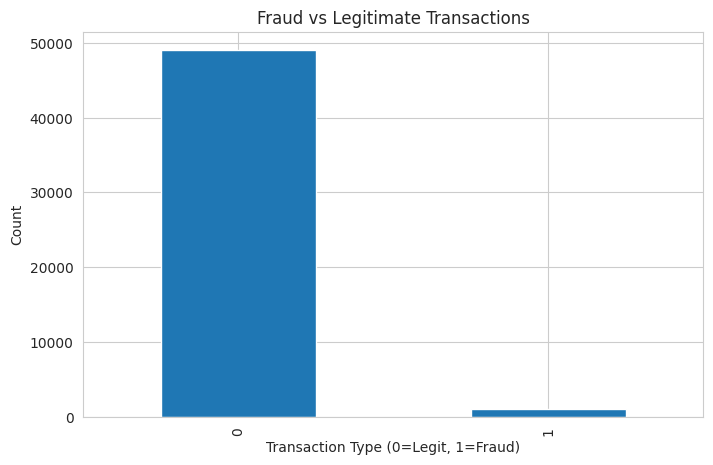

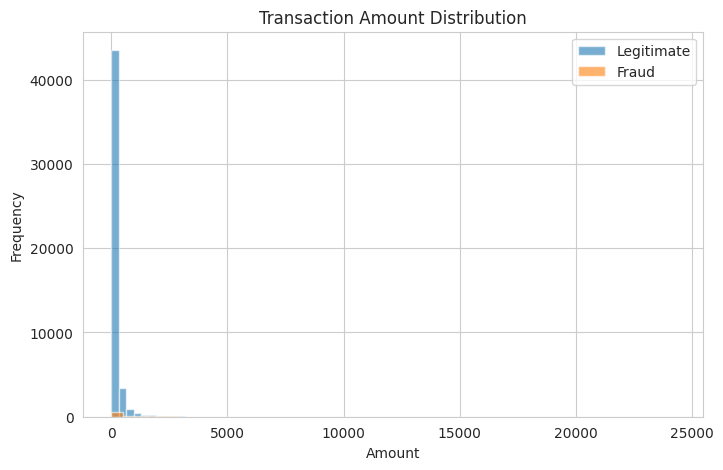

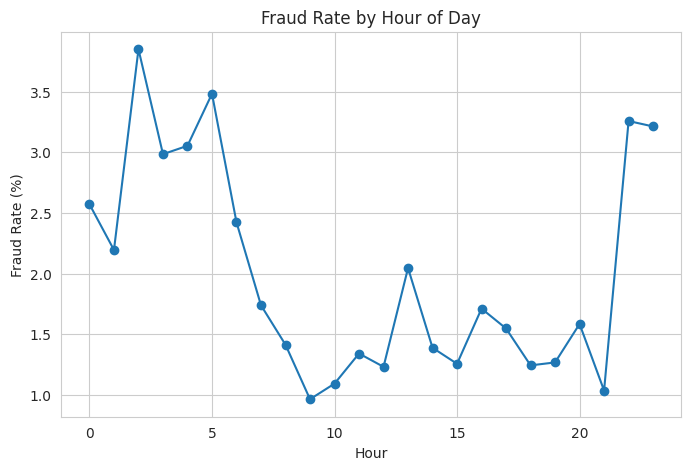

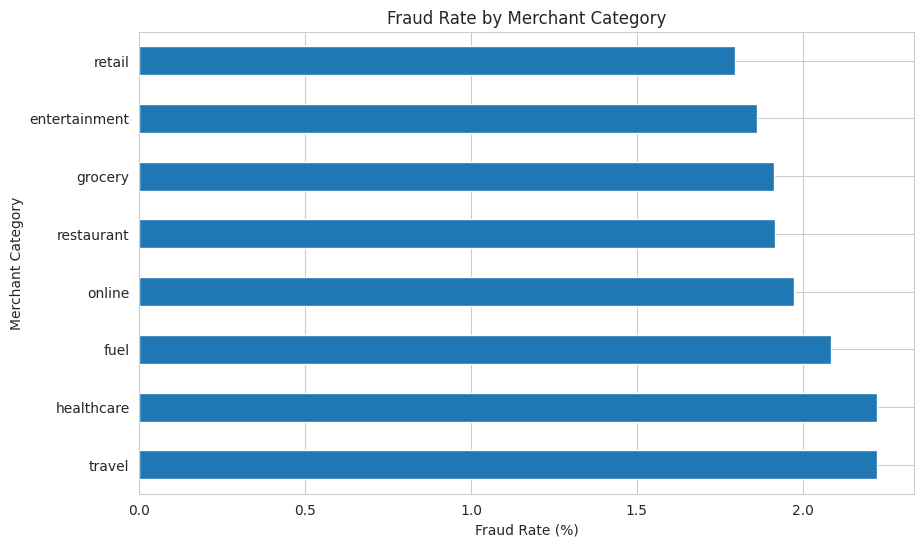


📊 Feature Correlations with Fraud:
is_fraud                 1.000000
transaction_amount       0.283472
amount_vs_avg            0.065090
is_night                 0.055686
customer_id              0.006775
transaction_count        0.001244
is_high_risk_category    0.001198
is_weekend               0.000436
day_of_week             -0.003454
transaction_hour        -0.021904
location_match          -0.104003
Name: is_fraud, dtype: float64


In [9]:
# ====================================================================
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
# ====================================================================
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Basic statistics
print("\n📊 Statistical Summary:")
print(df.describe())

# Fraud distribution
print("\n🎯 Fraud Distribution:")
print(df['is_fraud'].value_counts())
print(f"\nFraud Rate: {df['is_fraud'].mean()*100:.2f}%")

# Visualization 1: Fraud Count
plt.figure(figsize=(8, 5))
df['is_fraud'].value_counts().plot(kind='bar')
plt.title('Fraud vs Legitimate Transactions')
plt.xlabel('Transaction Type (0=Legit, 1=Fraud)')
plt.ylabel('Count')
plt.show()

# Visualization 2: Transaction Amount Distribution
plt.figure(figsize=(8, 5))
plt.hist(df[df['is_fraud'] == 0]['transaction_amount'], bins=50, alpha=0.6, label='Legitimate')
plt.hist(df[df['is_fraud'] == 1]['transaction_amount'], bins=50, alpha=0.6, label='Fraud')
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Visualization 3: Fraud Rate by Hour
fraud_by_hour = df.groupby('transaction_hour')['is_fraud'].mean() * 100
plt.figure(figsize=(8, 5))
plt.plot(fraud_by_hour.index, fraud_by_hour.values, marker='o')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate (%)')
plt.grid(True)
plt.show()

# Visualization 4: Fraud Rate by Merchant Category
fraud_by_category = df.groupby('merchant_category')['is_fraud'].mean() * 100
fraud_by_category = fraud_by_category.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
fraud_by_category.plot(kind='barh')
plt.title('Fraud Rate by Merchant Category')
plt.xlabel('Fraud Rate (%)')
plt.ylabel('Merchant Category')
plt.show()

# Correlation Analysis
print("\n📊 Feature Correlations with Fraud:")
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_with_fraud = df[numerical_cols].corr()['is_fraud'].sort_values(ascending=False)
print(correlation_with_fraud)

In [10]:
# ====================================================================
# STEP 4: DATA PREPROCESSING & FEATURE ENGINEERING
# ====================================================================
print("\n" + "="*80)
print("DATA PREPROCESSING & FEATURE ENGINEERING")
print("="*80)

df_processed = df.copy()

# Time-based features
df_processed['month'] = df_processed['transaction_date'].dt.month
df_processed['day_of_month'] = df_processed['transaction_date'].dt.day
df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['transaction_hour'] / 24)
df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['transaction_hour'] / 24)

# Customer aggregations
customer_features = df_processed.groupby('customer_id').agg({
    'transaction_amount': ['mean', 'std', 'max', 'count'],
    'is_fraud': 'sum'
}).reset_index()
customer_features.columns = [
    'customer_id', 'cust_avg_amount', 'cust_std_amount', 'cust_max_amount', 'cust_total_txns', 'cust_fraud_count'
]
df_processed = df_processed.merge(customer_features, on='customer_id', how='left')

# Amount-based features
df_processed['amount_log'] = np.log1p(df_processed['transaction_amount'])
df_processed['amount_zscore'] = (df_processed['transaction_amount'] - df_processed['transaction_amount'].mean()) / (df_processed['transaction_amount'].std() + 1e-9)

# Composite risk score (numeric)
df_processed['risk_score'] = (
    df_processed['is_night'] * 2.0 +
    df_processed['is_high_risk_category'] * 1.5 +
    (~df_processed['location_match'].astype(bool)).astype(int) * 2.0 +
    (df_processed['amount_vs_avg'] > 2).astype(int) * 1.5 +
    (df_processed['transaction_count'] > 3).astype(int) * 1.0
)

print("✓ Advanced features created")

# Encode categorical variables
print("\n🔄 Encoding categorical variables...")
label_encoders = {}
categorical_cols = ['merchant_category', 'transaction_type', 'device_type']
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = df_processed[col].astype(str).fillna('NA')
    df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
print("✓ Categorical encoding complete")

# Feature selection for modeling
feature_columns = [
    'transaction_amount', 'transaction_hour', 'day_of_week', 'is_weekend',
    'is_night', 'is_high_risk_category', 'location_match', 'amount_vs_avg',
    'transaction_count', 'month', 'day_of_month', 'hour_sin', 'hour_cos',
    'cust_avg_amount', 'cust_std_amount', 'cust_max_amount', 'cust_total_txns',
    'cust_fraud_count', 'amount_log', 'amount_zscore', 'risk_score',
    'merchant_category_encoded', 'transaction_type_encoded', 'device_type_encoded'
]

# Ensure all feature columns exist (fill missing with zeros)
for c in feature_columns:
    if c not in df_processed.columns:
        df_processed[c] = 0

X = df_processed[feature_columns].fillna(0)
y = df_processed['is_fraud'].astype(int)

print(f"\n✓ Feature matrix shape: {X.shape}")
print(f"✓ Target variable shape: {y.shape}")

# ====================================================================
# STEP 5: TRAIN-TEST SPLIT & DATA BALANCING
# ====================================================================
print("\n" + "="*80)
print("TRAIN-TEST SPLIT & DATA BALANCING")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")
print(f"\nTraining set fraud rate: {y_train.mean()*100:.2f}%")
print(f"Test set fraud rate: {y_test.mean()*100:.2f}%")

# Scaling
print("\n⚖️ Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Feature scaling complete")

# Handle imbalance with SMOTE
print("\n⚖️ Balancing classes with SMOTE...")
print(f"Before SMOTE - Fraud cases: {int(y_train.sum())}")
smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
print(f"After SMOTE - Fraud cases: {int(y_train_balanced.sum())}")
print(f"✓ Balanced training set shape: {X_train_balanced.shape}")


DATA PREPROCESSING & FEATURE ENGINEERING
✓ Advanced features created

🔄 Encoding categorical variables...
✓ Categorical encoding complete

✓ Feature matrix shape: (50000, 24)
✓ Target variable shape: (50000,)

TRAIN-TEST SPLIT & DATA BALANCING

✓ Training set: 40000 samples
✓ Test set: 10000 samples

Training set fraud rate: 2.00%
Test set fraud rate: 2.00%

⚖️ Scaling features...
✓ Feature scaling complete

⚖️ Balancing classes with SMOTE...
Before SMOTE - Fraud cases: 800
After SMOTE - Fraud cases: 19600
✓ Balanced training set shape: (58800, 24)



MODEL 1: LOGISTIC REGRESSION
✓ Logistic Regression training complete

📊 LOGISTIC REGRESSION PERFORMANCE:

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.99      1.00      9800
       Fraud       0.74      0.98      0.84       200

    accuracy                           0.99     10000
   macro avg       0.87      0.99      0.92     10000
weighted avg       0.99      0.99      0.99     10000

Accuracy: 99.27%
Precision: 73.96%
Recall: 98.00%
F1-Score: 84.30%
ROC-AUC: 0.9895


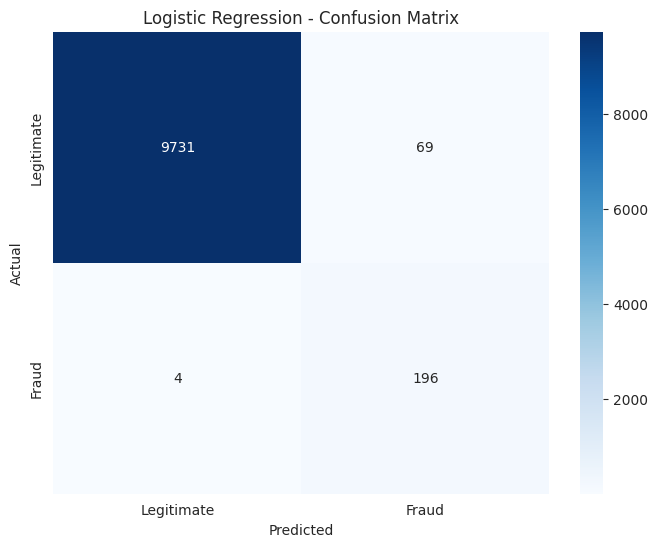

In [11]:
# ====================================================================
# STEP 6: MODEL DEVELOPMENT - LOGISTIC REGRESSION
# ====================================================================
print("\n" + "="*80)
print("MODEL 1: LOGISTIC REGRESSION")
print("="*80)

lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, C=0.1)
lr_model.fit(X_train_balanced, y_train_balanced)
print("✓ Logistic Regression training complete")

# Predictions & evaluation
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("\n📊 LOGISTIC REGRESSION PERFORMANCE:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Legitimate', 'Fraud']))

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_lr, zero_division=0)*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_lr, zero_division=0)*100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_pred_lr, zero_division=0)*100:.2f}%")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



MODEL 2: RANDOM FOREST
✓ Random Forest training complete

📊 RANDOM FOREST PERFORMANCE:

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.99      1.00      9800
       Fraud       0.78      0.97      0.87       200

    accuracy                           0.99     10000
   macro avg       0.89      0.98      0.93     10000
weighted avg       1.00      0.99      0.99     10000

Accuracy: 99.40%
Precision: 78.23%
Recall: 97.00%
F1-Score: 86.61%
ROC-AUC: 0.9994


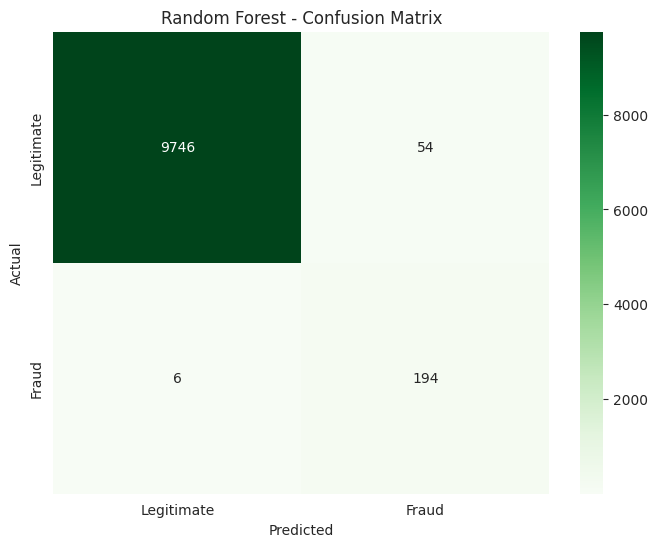


📊 Top 10 Most Important Features:
            feature  importance
   cust_fraud_count    0.626795
      amount_zscore    0.062212
 transaction_amount    0.048501
    cust_avg_amount    0.040405
         amount_log    0.037679
    cust_max_amount    0.024335
     location_match    0.023276
         risk_score    0.022194
      amount_vs_avg    0.020048
device_type_encoded    0.013953


<Figure size 1000x600 with 0 Axes>

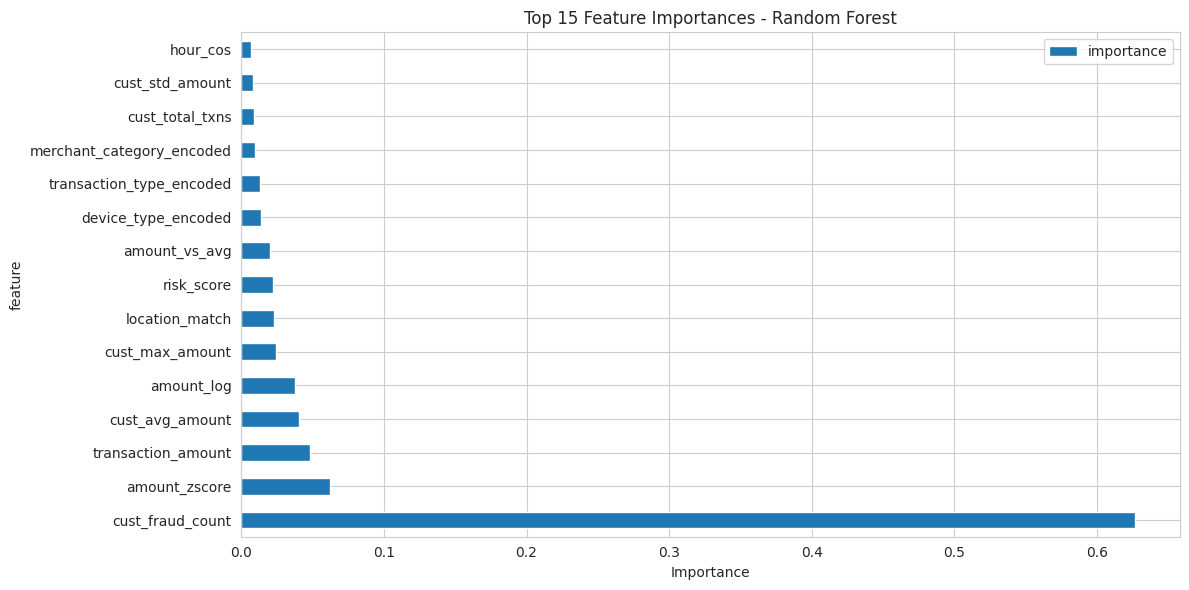

In [12]:
# ====================================================================
# STEP 7: MODEL DEVELOPMENT - RANDOM FOREST
# ====================================================================
print("\n" + "="*80)
print("MODEL 2: RANDOM FOREST")
print("="*80)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)
print("✓ Random Forest training complete")

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\n📊 RANDOM FOREST PERFORMANCE:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Legitimate', 'Fraud']))

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_rf, zero_division=0)*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_rf, zero_division=0)*100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_pred_rf, zero_division=0)*100:.2f}%")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature importance
print("\n📊 Top 10 Most Important Features:")
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
feature_importance.head(15).plot(x='feature', y='importance', kind='barh')
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()



MODEL COMPARISON


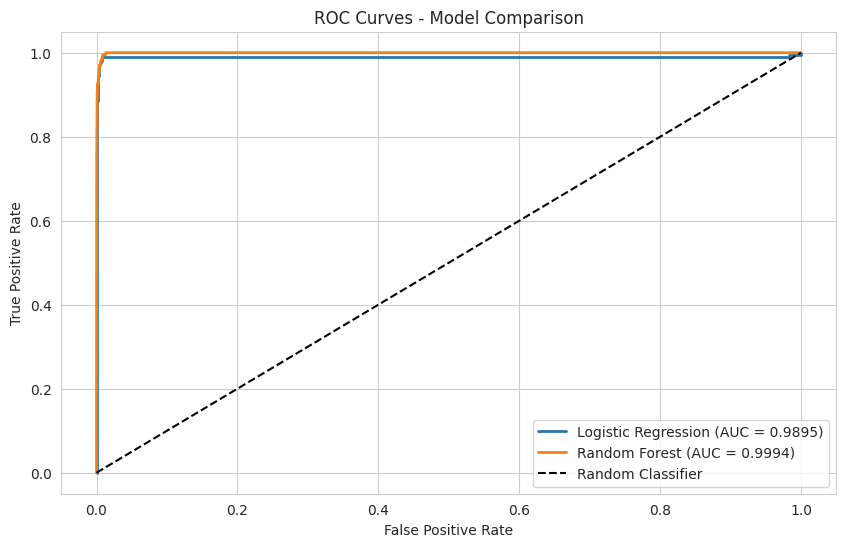

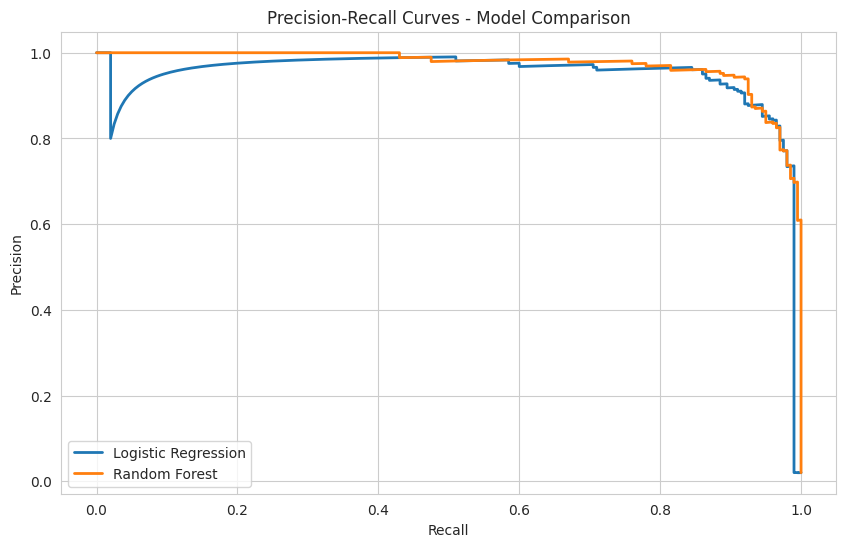


📊 MODEL PERFORMANCE COMPARISON:
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.9927   0.739623    0.98  0.843011 0.989512
      Random Forest    0.9940   0.782258    0.97  0.866071 0.999416


In [13]:
# ====================================================================
# STEP 8: MODEL COMPARISON & ROC CURVES
# ====================================================================
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.4f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True)
plt.show()

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 6))
plt.plot(recall_lr, precision_lr, label='Logistic Regression', linewidth=2)
plt.plot(recall_rf, precision_rf, label='Random Forest', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Model Comparison')
plt.legend()
plt.grid(True)
plt.show()

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf)],
    'Precision': [precision_score(y_test, y_pred_lr, zero_division=0), precision_score(y_test, y_pred_rf, zero_division=0)],
    'Recall': [recall_score(y_test, y_pred_lr, zero_division=0), recall_score(y_test, y_pred_rf, zero_division=0)],
    'F1-Score': [f1_score(y_test, y_pred_lr, zero_division=0), f1_score(y_test, y_pred_rf, zero_division=0)],
    'ROC-AUC': [roc_auc_score(y_test, y_pred_proba_lr), roc_auc_score(y_test, y_pred_proba_rf)]
})
print("\n📊 MODEL PERFORMANCE COMPARISON:")
print(comparison_df.to_string(index=False))


In [14]:
# ====================================================================
# STEP 9: EXPORT DATA FOR POWER BI
# ====================================================================
print("\n" + "="*80)
print("EXPORTING DATA FOR POWER BI")
print("="*80)

# Prepare df_powerbi (use scaler to transform all features before prediction)
X_all_scaled = scaler.transform(X)  # same feature ordering as X
df_powerbi = df_processed.copy()

df_powerbi['predicted_fraud_lr'] = lr_model.predict(X_all_scaled)
df_powerbi['fraud_probability_lr'] = lr_model.predict_proba(X_all_scaled)[:, 1]
df_powerbi['predicted_fraud_rf'] = rf_model.predict(X_all_scaled)
df_powerbi['fraud_probability_rf'] = rf_model.predict_proba(X_all_scaled)[:, 1]

# Risk categories & alert flag
df_powerbi['risk_category'] = pd.cut(df_powerbi['fraud_probability_rf'], bins=[0, 0.3, 0.6, 1.0], labels=['Low Risk', 'Medium Risk', 'High Risk'])
df_powerbi['alert_flag'] = (df_powerbi['fraud_probability_rf'] > 0.5).astype(int)

# Export to Excel
print("\n💾 Exporting to Excel...")
with pd.ExcelWriter('fraud_detection_data.xlsx', engine='openpyxl') as writer:
    df_powerbi.to_excel(writer, sheet_name='Transactions', index=False)
    comparison_df.to_excel(writer, sheet_name='Model_Performance', index=False)
    feature_importance.to_excel(writer, sheet_name='Feature_Importance', index=False)
print("✓ Data exported to: fraud_detection_data.xlsx")

# Export to CSV
df_powerbi.to_csv('fraud_transactions.csv', index=False)
print("✓ Data exported to: fraud_transactions.csv")

summary_stats = pd.DataFrame({
    'Metric': ['Total Transactions', 'Fraud Cases', 'Fraud Rate (%)', 'Avg Transaction Amount', 'Alerts Generated', 'Alert Rate (%)'],
    'Value': [
        len(df_powerbi),
        int(df_powerbi['is_fraud'].sum()),
        df_powerbi['is_fraud'].sum() / len(df_powerbi) * 100,
        df_powerbi['transaction_amount'].mean(),
        int(df_powerbi['alert_flag'].sum()),
        df_powerbi['alert_flag'].sum() / len(df_powerbi) * 100
    ]
})
print("\n📊 SUMMARY STATISTICS FOR DASHBOARD:")
print(summary_stats.to_string(index=False))

# ====================================================================
# STEP 10: DOWNLOAD INSTRUCTIONS (COLAB)
# ====================================================================
print("\n" + "="*80)
print("FILES READY FOR DOWNLOAD")
print("="*80)
print("""
📥 Download these files from Colab:
1. fraud_detection_data.xlsx - Complete dataset with predictions
2. fraud_transactions.csv - Transaction data in CSV format

To download from Google Colab:
- Click on the folder icon on the left sidebar
- Right-click on the file and select 'Download'
""")
print("\n✅ PROJECT COMPLETE!")
print("="*80)


EXPORTING DATA FOR POWER BI

💾 Exporting to Excel...
✓ Data exported to: fraud_detection_data.xlsx
✓ Data exported to: fraud_transactions.csv

📊 SUMMARY STATISTICS FOR DASHBOARD:
                Metric        Value
    Total Transactions 50000.000000
           Fraud Cases  1000.000000
        Fraud Rate (%)     2.000000
Avg Transaction Amount   178.326718
      Alerts Generated  1223.000000
        Alert Rate (%)     2.446000

FILES READY FOR DOWNLOAD

📥 Download these files from Colab:
1. fraud_detection_data.xlsx - Complete dataset with predictions
2. fraud_transactions.csv - Transaction data in CSV format

To download from Google Colab:
- Click on the folder icon on the left sidebar
- Right-click on the file and select 'Download'


✅ PROJECT COMPLETE!


In [15]:
# ============================================================
# STEP 11: EXPORT TRAINED MODELS (PKL FILES)
# ============================================================
import joblib
from google.colab import files

print("\nSaving trained models...")

# Save models
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(lr_model, "logistic_regression_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✓ Models saved as PKL files")

# Download models
files.download("random_forest_model.pkl")
files.download("logistic_regression_model.pkl")
files.download("scaler.pkl")

print("\n📥 All model files downloaded successfully!")



Saving trained models...
✓ Models saved as PKL files


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📥 All model files downloaded successfully!
